In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
## Import for partitioning the data
from sklearn.model_selection import train_test_split
## Classifier Imports
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
# Imports for showing the data
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn import tree
# Import for saving the model
from joblib import dump, load


### Reading in the data##################################################################################
dat = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv")
#########################################################################################################

### Encoding the data ###################################################################################
### Assigning number values to all strings and removing 'contact' and 'day_of_week'
## Seperating numerical and categorical so numerical does not get encoded
dat_cat = dat.drop(["age", "campaign", "pdays",	"previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", 'contact', 'day_of_week'], axis = 1)
dat_num = dat.drop(["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome", "y"], axis = 1)

# Rejoining numerical and categorical
dat_encoded = dat_cat.apply(preprocessing.LabelEncoder().fit_transform)
dat_encoded = pd.concat([dat_num, dat_encoded], axis=1)
##########################################################################################################

#####Creating the High and Low Economy####################################################################
dat_high = dat_encoded[ dat_encoded["cons.conf.idx"] >= -37]
dat_low = dat_encoded[ dat_encoded["cons.conf.idx"] < -37]

#dat_majority =dat[dat['y' == 'no']]
#dat_majority =dat[dat['y' == 'yes']]
#sampleAmount = len(dat_majority)
##########################################################################################################

### Creating the features and the target##################################################################
X = dat_encoded.drop('y', axis=1)
y = dat_encoded['y']

X_high = dat_high.drop('y', axis=1)
y_high = dat_high['y']

X_low = dat_low.drop('y', axis=1)
y_low = dat_low['y']

## Partitioning the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.20)
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.20)
###########################################################################################################

####OVERSAMPLING###########################################################################################
from imblearn.over_sampling import RandomOverSampler
# https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html


# Let's over sample the minority class, which samples with replacement until the
# majority (died) and the minority (survived) are equal
ro = RandomOverSampler()

# Oversample, note that we oversample X and y at the same time in order to 
# make sure our features and targets stay synched.
X_train_new, y_train_new = ro.fit_resample(X_train, y_train)
X_test_new, y_test_new = ro.fit_resample(X_test, y_test)

X_train_new_high, y_train_new_high = ro.fit_resample(X_train_high, y_train_high)
X_test_new_high, y_test_new_high = ro.fit_resample(X_test_high, y_test_high)

X_train_new_low, y_train_new_low = ro.fit_resample(X_train_low, y_train_low)
X_test_new_low, y_test_new_low = ro.fit_resample(X_test_low, y_test_low)
############################################################################################################

#### Three different types of classifiers that were tried###################################################

### OG Classifier
### Was nice, but only can do so much
#classifier = DecisionTreeClassifier()
#classifier.fit(X_train_new, y_train_new)


### Forest Classifier
### A forest of decision trees.
### Best precision of the three at ~0.86, but recall was low at ~0.38
#clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
#clf = clf.fit(X_train_new, y_train_new)

##Bagging Classifier
# Personal Favorite and makes the most sense to use because of how deep our decision tree is.
# Best Recall at ~0.64 and precision at ~0.80
clf = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.25)
clf = clf.fit(X_train_new, y_train_new)

clf_high = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.25)
clf_high = clf_high.fit(X_train_new_high, y_train_new_high)

clf_low = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.25)
clf_low = clf_low.fit(X_train_new_low, y_train_new_low)
#############################################################################################################

####Saving the Model#########################################################################################
#dump(clf, 'teddyjustrightModel.joblib')
#dump(clf_high, 'teddy2highModel.joblib')
#dump(clf_low, 'teddy2lowModel.joblib') 
#############################################################################################################

##PREDICITON TIME############################################################################################
y_pred = clf.predict(X_test_new)

y_pred_high = clf_low.predict(X_test_new_high)

y_pred_low = clf_high.predict(X_test_new_low)

## Displaying the data

print(confusion_matrix(y_test_new, y_pred))
print(classification_report(y_test_new, y_pred))

print(confusion_matrix(y_test_new_high, y_pred_high))
print(classification_report(y_test_new_high, y_pred_high))

print(confusion_matrix(y_test_new_low, y_pred_low))
print(classification_report(y_test_new_low, y_pred_low))

print(len(X_test))
print(len(X_test_high))
print(len(X_test_low))
#print(dat_high["cons.conf.idx"].value_counts())

### Showing the tree, but it takes a hot minute cause the tree is so big
#fig, ax = plt.subplots(figsize=(20, 20))
#tree.plot_tree(classifier, fontsize=10, feature_names=X.columns)
#plt.show()
##############################################################################################################

[[6234 1094]
 [2752 4576]]
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      7328
           1       0.81      0.62      0.70      7328

    accuracy                           0.74     14656
   macro avg       0.75      0.74      0.73     14656
weighted avg       0.75      0.74      0.73     14656

[[1066 1729]
 [ 494 2301]]
              precision    recall  f1-score   support

           0       0.68      0.38      0.49      2795
           1       0.57      0.82      0.67      2795

    accuracy                           0.60      5590
   macro avg       0.63      0.60      0.58      5590
weighted avg       0.63      0.60      0.58      5590

[[3276 1228]
 [1634 2870]]
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      4504
           1       0.70      0.64      0.67      4504

    accuracy                           0.68      9008
   macro avg       0.68      0.68      0.68    

<ipython-input-110-7a55480516f9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2["age_group"] = pd.cut(dat2['age'], bins = bins, labels = labels, right = False)
<ipython-input-110-7a55480516f9>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3["age_group"] = pd.cut(dat3['age'], bins = bins, labels = labels, right = False)


Text(0.42499999999999716, 0.5, 'Subscribed')

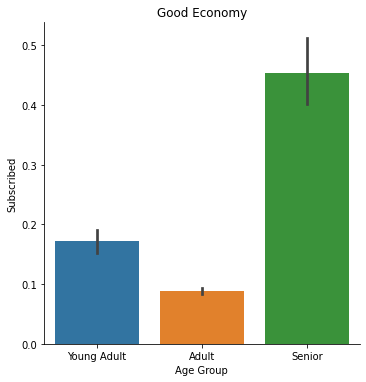

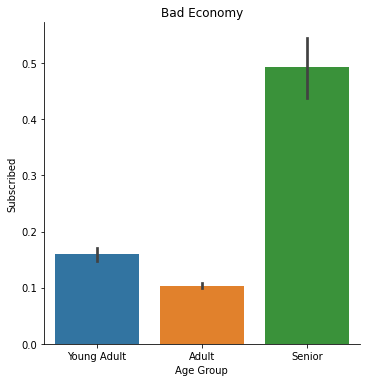

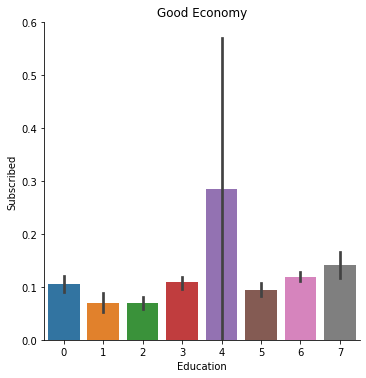

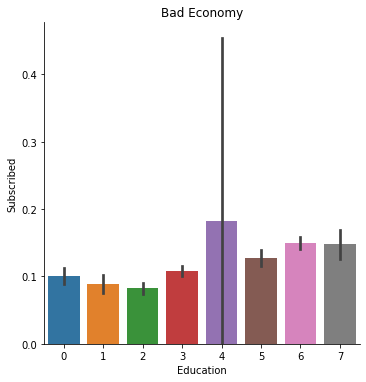

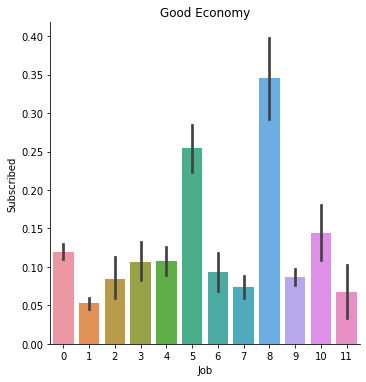

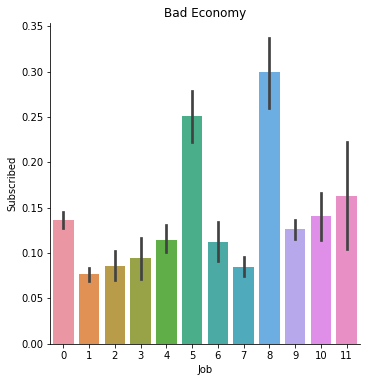

In [110]:
from sklearn.cluster import KMeans

dat = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv")
#dat['unencoded_job'] = dat['job']
dat_cat = dat.drop(["age", "campaign", "pdays",	"previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", 'contact', 'day_of_week'], axis = 1)
dat_num = dat.drop(["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome", "y"], axis = 1)

# Rejoining numerical and categorical
dat_encoded = dat_cat.apply(preprocessing.LabelEncoder().fit_transform)
dat_encoded = pd.concat([dat_num, dat_encoded], axis=1)

dat_high = dat_encoded[ dat_encoded["cons.conf.idx"] >= -37]
dat_low = dat_encoded[ dat_encoded["cons.conf.idx"] < -37]

#kmeans = KMeans(n_clusters=4).fit(dat_encoded)
#centroids = kmeans.cluster_centers_
#print(centroids)
#plt.scatter(dat['previous'], dat['y'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
#plt.show()

dat2 = dat_high
#dat2['day_of_week'] = dat2['day_of_week'].map({'mon': 0, 'tue': 0, 'wed': 1, 'thurs': 1, 'fri': 2, 'sat': 2, 'sun': 2})

#dat2 = dat[dat['previous'] != 0]
bins = [18,30,65,100]
labels = ['Young Adult', "Adult", 'Senior']
dat2["age_group"] = pd.cut(dat2['age'], bins = bins, labels = labels, right = False)

#dat2['subscribed'] = dat2['y'].map({'yes': 1, 'no': 0})

dat3 = dat_low
dat3["age_group"] = pd.cut(dat3['age'], bins = bins, labels = labels, right = False)

#dat3['subscribed'] = dat3['y'].map({'yes': 1, 'no': 0})
#dat.day_of_week.value_counts()
#sns.countplot(data = dat,  x = "previous", hue="y").set_title("Amount of Contacts in Previous Campaign")
#dat.previous.value_counts()
sns.catplot(data = dat2, x = "age_group", y = 'y', kind = 'bar')
plt.title("Good Economy")
plt.xlabel("Age Group")
plt.ylabel("Subscribed")

sns.catplot(data = dat3, x = "age_group", y = 'y', kind = 'bar')
plt.title("Bad Economy")
plt.xlabel("Age Group")
plt.ylabel("Subscribed")

sns.catplot(data = dat2, x = "education", y = 'y', kind = 'bar')
plt.title("Good Economy")
plt.xlabel("Education")
plt.ylabel("Subscribed")

sns.catplot(data = dat3, x = "education", y = 'y', kind = 'bar')
plt.title("Bad Economy")
plt.xlabel("Education")
plt.ylabel("Subscribed")

sns.catplot(data = dat2, x = "job", y = 'y', kind = 'bar')
plt.title("Good Economy")
plt.xlabel("Job")
plt.ylabel("Subscribed")

sns.catplot(data = dat3, x = "job", y = 'y', kind = 'bar')
plt.title("Bad Economy")
plt.xlabel("Job")
plt.ylabel("Subscribed")

#dat.head(7786)
#dat3.head(40)